In [ ]:
# compare and test association using mutual info

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import ppscore as pps
import pandas as pd
from scipy.stats import f_oneway
from collections import Counter
import math
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import chisquare

## The search for universal correlation

Being able to measure correlation or relationship in general between variables are important because you it allows you to:

1) Perform feature selection effectively. How do you reduce and only retain the best variables for modelling?

2) Narrowing down to the crucial variables so that you could save tons of time during EDA. We often have at least 10-20 variables to look at. If we inspect all the possible pairs of relationships by plotting and applying the appropriate technique for that particular pair of variables, it's going to suck our soul dry. Is there a more efficient way to do it?

One of the problem in this area is that we don't have a common and comparable measure due to the nature of the variable. Today, we are going to take a deep dive into this topic and perhaps we can arrive with an universal measure that could serve us well.

In [3]:
#generate 4 X
np.random.seed(888)
n = 1000
noise_level = 0.15
X, y = np.random.rand(n, 4), np.zeros((n,4))

## Correlation between Continuous-Continuous variables

There are many ways to measure the association between 2 Continuous variables, each with its own pros and cons:

### Pearson Correlation Coefficient
Pearson Correlation Coefficient measures the linear correlation
<img src='https://www.gstatic.com/education/formulas2/355397047/en/correlation_coefficient_formula.svg' width=220/>

1) Relationship is assumed to be linearly dependent.

2) Normally distributed

3) Bounded between -1 to 1

### Spearman rank correlation coefficient
The Spearman correlation is measures the monotonic relationship between two variables.

<img src='https://www.gstatic.com/education/formulas2/355397047/en/spearman_s_rank_correlation_coefficient.svg' width=180/>

1) Non-parametric measure(doesn't assume normality)

2) Monotonicity measures the "general direction" rather than a more constrainted "for each unit of X, Y grows by 1 unit".

3) Bounded from -1 to +1

### Mutual information (MI)
Mutual information is a measure of the inherent dependence expressed in the joint distribution of X and Y, relative to the marginal distribution of X & Y under the assumption of independence. The assumption is that if X and Y are independent, than the joint distribution wouldnt be very different from the product of their individual distributions:
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/9e6f5a4ad28d98e4f1905cbf51a9ef6a50334128'/>

1) Non-parametric measure(doesn't assume normality); methods based on entropy estimation from k-nearest neighbors distances.

2) Detects any relationship

3) Bounded from 0(no relationship) to <b>inf</b>

4) Being nonparametric, they require more samples for accurate estimation.

5) Available conveniently in scikit-learn library(mutual_info_regression)

Add. reference: 
https://stats.stackexchange.com/questions/68035/why-dont-statisticians-use-mutual-information-as-a-measure-of-association/68047

### F-test for regression
This one is often not talked about in data science but the implementation is surpringly available in scikit-learn library(sklearn.feature_selection.f_regression)

It essentially performs the F-test for regression, by fitting a linear regression model and compute the F-statistic and the associated p-value, which test whether the independent variable in such model is significant.

Add. references:

https://stats.stackexchange.com/a/253255

http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm


### Predictive Power Score (PPS)
A new method to measure non-linear and asymmetric relationship, by attempting to fit a machine learning model(can be a linear or tree-based model) using the 2 variables, and use the error of the fit as the strength of the relationship.

Some advantages over other methods:

1) The score is asymmetric; eg. Given zipcode, you can easily predict city, but given city, can we predict the zipcode? Asymmetric relationships are common in the world and having the ability to describe it is important. In comparsion to Pearson correlation, which is a symmetric measure(

2) Flexible; it can work for categorical and Continuous variables, 1 handy measure to fit all scenarios which reduce the complexity of analysis.

Let's compare these measures and see how they perform in different circumstances.

### Putting it into examples

In [4]:
# generate some fake data
np.random.seed(888)
# add a little noise to make it look realistic
noise = noise_level * np.random.randn(n)
#generate 4 different Y pattersn
#linear
y[:,0] = X[:, 0] + noise 
#quadratic
X[:, 1] = np.linspace(-4,4, n) + noise
y[:, 1] = X[:, 1]**2  + noise
#sine curve
y[:,2] = np.sin(6 * np.pi * X[:, 2]) + noise
#random
y[:,3] = 0.1 * np.random.randn(n)

In [5]:
def calc_pps(x, y):
    tmp = pd.DataFrame({'x':x,'y':y})
    return pps.score(tmp, "x", "y")['ppscore']

In [6]:
# compute f
f_matrix = np.array([0.0]*X.shape[1])
for i in range(X.shape[1]):
    f_matrix[i], _ = f_regression(X[:,i].reshape(-1,1),y[:,i])
#normalize F
f_matrix = f_matrix/np.max(f_matrix)

# compute MI
mi_matrix = np.array([0.0]*X.shape[1])
for i in range(X.shape[1]):
    mi_matrix[i] = mutual_info_regression(X[:,i].reshape(-1,1),y[:,i])
#normalize MI
mi_matrix = mi_matrix/np.max(mi_matrix)

r_matrix = [0.0]*X.shape[1]
for i in range(X.shape[1]):
    r_matrix[i], _ = pearsonr(X[:,i],y[:,i])
    
p_matrix = [0.0]*X.shape[1]
for i in range(X.shape[1]):
    p_matrix[i], _ = spearmanr(X[:,i],y[:,i])
    
pp_matrix = [0.0]*X.shape[1]
for i in range(X.shape[1]):
    pp_matrix[i] = calc_pps(X[:,i],y[:,i])    
    

In [7]:
all_corr = np.stack((f_matrix, mi_matrix, r_matrix, p_matrix, pp_matrix),axis=1)

### Visualizing comparsion of correlation measures

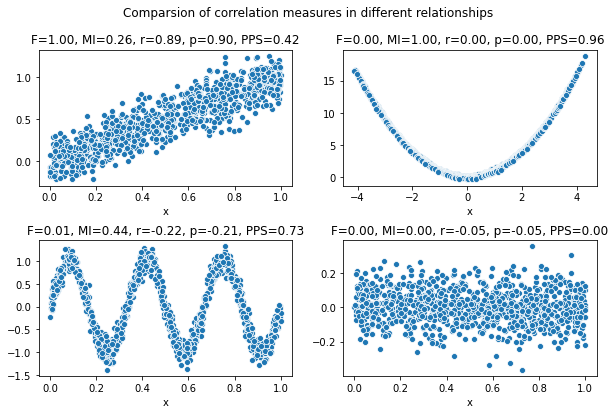

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
fig.subplots_adjust(hspace=0.4)
fig.suptitle('Comparsion of correlation measures in different relationships')

#iterate through subplots and populate them
for i, ax in enumerate(axes.flatten()):
    
    sns.scatterplot(X[:, i], y[:,i], ax=ax)#, linewidth=0)
    #ax.scatter(X[:, i], y[:,i], s=20) # or plain matplotlib
    
    ax.set(title="F={:.2f}, MI={:.2f}, r={:.2f}, p={:.2f}, PPS={:.2f}".format(*[j for j in all_corr[i]]), xlabel='x')
    #ax.set(title="F={:.2f}, MI={:.2f}, r={:.2f}, p={:.2f}, pp={:.2f}".format(*[j for j in all_corr[i]]), xlabel='x') # or plain matplotlib
    

Note that the F-value and MI are unbounded, and they have been normalized for easy comparsion.

1) First (Linear relationship): All except for MI(maybe PPS as well) shows high amount of correlation values

2) Second (Quadratic relationship): As expected, all measures that assumes linearity falls flat. Only MI and PPS could reflect the relationship.

3) Third (Non-linear relationship): All except MI and PPS doesn't give a correct picture of the underlying relationship.

4) Fourth (No relationship at all): As expected, there's no relationship.

We could see that PPS serves pretty well as a reliable measure across the different relationships.

## Correlation between Continuous and Categorical



### Correlation ratio

The <b>correlation ratio, which is a measure of association between Continuous and categorical variables</b>.

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/c88107a476ba4900035c09cd1c8a4f0b67f87abe'/>

The correlation ratio η (eta) is defined as the weighted variance of the category means divided by the variance of all samples, where $\bar{y}_{x}$ is the mean of the category x and $\bar{y}$ is the mean of the whole population.

In human language, the Correlation Ratio answers the following question: Given a continuous number, how well can you know to which category it belongs to? Just like the two coefficients we’ve seen before, here too the output is on the range of 0 to 1.

For n=1, the overall sample dispersion is purely due to dispersion among the categories and not at all due to dispersion within the individual categories. There is a real difference between the categories.

For n=0, it means no dispersion among the means of the different categories. There is no difference between the categories.


### ANOVA

We could also use <b>ANOVA</b> to compare means of more than 2 groups. The ANOVA method assesses the relative size of variance among group means (between group variance) compared to the average variance within groups (within group variance).
<img src='https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3916511/bin/rde-39-74-e001.jpg'/>
Larger F value than the critical value(often 0.05) supports that the differences between group means are larger than what would be expected by chance.

<b>Differences between ANOVA and correlation ratio:</b>

ANOVA is a statistical test where we frame it as a hypothesis that there's no differences and we compute a test statistic to reject(validate) that hypothesis. The output is either a yes or not in terms of whether there's an association between the groups(statistically significant or not) . It doesn’t tell you the magnitude of that association.

On the other hand, correlation ratio gives you a measure of association which you could direct reason about the strength of their relationship.

See <a href='https://blog.minitab.com/en/understanding-statistics/three-things-the-p-value-cant-tell-you-about-your-hypothesis-test'>this post</a> on more p-value limitations.

1) ANOVA assumed that the samples comes from equal variance.

### Mutual information(MI)

As described previously, MI measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

1) Available conveniently in scikit-learn library(mutual_info_classfi)

### Machine learning models (through PPS)

Using a logistic regression to quantify the association can be a way as well, and it offers some robustness:

1) Continuous variables don’t have to be normally distributed or have equal variance in each group(assumption of ANOVA).

2) Can be affected by imbalanced class.

It can be easily implemented by the Predictive Power Score (PPS) we have talked about earlier.

More references:
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

### Putting it into examples

In [9]:
# create random sample, simulate real difference in purchase and no difference in gender
n_a, n_b = 100,100
np.random.seed(888)
pur_a = np.random.binomial(n=1, p=0.5,size=n_a)
pur_b = np.random.binomial(n=1, p=0.8,size=n_b)
#generate random normally distribted samples for simulating time spent
time_a = np.random.normal(3, 1, n_a)
time_b = np.random.normal(5, 1, n_b)
grp_type = np.random.binomial(n=1, p=0.5,size=n_a+n_b)
dataset = pd.DataFrame({'gender':grp_type,
                        'purchase':list(pur_a)+list(pur_b),
                       'time_spent':list(time_a)+list(time_b)}
                      )
# convert data type to categorical so that PPS will know that they are cat. vars.
dataset['gender'] = dataset['gender'].astype(str)
dataset['purchase'] = dataset['purchase'].astype(str)
dataset.head()

,gender,purchase,time_spent
0,0,1,5.407855
1,1,0,4.301718
2,0,0,1.674725
3,0,1,4.687605
4,0,0,3.411356


In [10]:
#compute ANOVA
anova_pvals = np.zeros(2)
F, p = f_oneway(dataset.query('gender=="0"')['time_spent'].values, dataset.query('gender=="1"')['time_spent'].values)
anova_pvals[0] = p
F, p = f_oneway(dataset.query('purchase=="0"')['time_spent'].values, dataset.query('purchase=="1"')['time_spent'].values)
anova_pvals[1] = p

In [11]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [12]:
#compute correlation_ratio
corr_ratios = np.zeros(2)
corr_ratios[0] = correlation_ratio(dataset['gender'].values,dataset['time_spent'].values)
corr_ratios[1] = correlation_ratio(dataset['purchase'].values,dataset['time_spent'].values)

In [13]:
pp_matrix = np.zeros(2)
# note that it expects (x,y) so important to have categorical var at the back
pp_matrix[0] = calc_pps(dataset['time_spent'].values,dataset['gender'].values)
pp_matrix[1] = calc_pps(dataset['time_spent'].values,dataset['purchase'].values)

In [14]:
# MI for classification
from sklearn.feature_selection import mutual_info_classif

In [21]:
mi_matrix = np.zeros(2)
mi_matrix[0] = mutual_info_classif(dataset[['time_spent']],dataset['gender'],discrete_features=False)
mi_matrix[1] = mutual_info_classif(dataset[['time_spent']],dataset['purchase'],discrete_features=False)

In [23]:
all_corr = np.stack((anova_pvals, corr_ratios, mi_matrix, pp_matrix),axis=1)

### Visualizing comparsion of correlation measures

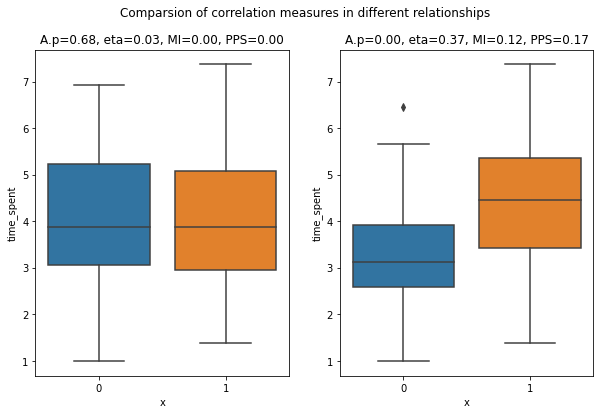

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
fig.subplots_adjust(hspace=0.4)
fig.suptitle('Comparsion of correlation measures in different relationships')

cat_feas = ['gender','purchase']
#iterate through subplots and populate them
for i, ax in enumerate(axes.flatten()):
    # note that catplot is not used because it has its own "frame"
    sns.boxplot(x=cat_feas[i], y="time_spent", data=dataset, ax=ax)
    
    #sns.scatterplot(X[:, i], y[:,i], ax=ax)#, linewidth=0)
    #ax.scatter(X[:, i], y[:,i], s=20) # or plain matplotlib
    
    ax.set(title="A.p={:.2f}, eta={:.2f}, MI={:.2f}, PPS={:.2f}".format(*[j for j in all_corr[i]]), xlabel='x')
    #ax.set(title="F={:.2f}, MI={:.2f}, r={:.2f}, p={:.2f}, pp={:.2f}".format(*[j for j in all_corr[i]]), xlabel='x') # or plain matplotlib
plt.show()

1) In the first example with no difference between the 2 groups, we could see that all measures show no association(p-value for ANOVA is high=not signifcant)

2) In the second example with noticable different between the 2 groups, we could see all measures show some strength in the association. The PPS didn't work as well as we thought, with a "correlation" with only 0.17. Perhaps the underlying Decision Tree Classifier isn't effective?

## Correlation between Categorical and Categorical

### Chi-square test(test of independence)
Test of independence test whether two (or more) groups have the save distribution. It's often confused with goodness of fit test, where you test whether one (discrete) random variable has a specific distribution.

A good way to think about the difference:

1) Use test of independence when you don't know the underlying distribution but you want to test whether two (or more) groups have the same distribution.

2) Use goodness of fit when you have a distribution in mind and you want to test whether a group matches that distribution.

### Theil’s U
Also known as the Uncertainty Coefficient, is based on the conditional entropy between x and y;  given the value of x, how many possible states does y have, and how often do they occur. The output value is on the range of [0,1], one advantage is that it is asymmetric, meaning U(x,y)≠U(y,x) (while V(x,y)=V(y,x), where V is Cramer’s V). 

### Mutual information (MI)

### PPS


### Putting it into examples

In [163]:
# create random sample, simulate real difference in purchase between gender but no difference in device
n_a, n_b = 100,100
np.random.seed(888)
#pur_a = np.
pur_a = np.random.binomial(n=1, p=0.5,size=n_a)
pur_b = np.random.binomial(n=1, p=0.75,size=n_b)
# #generate random normally distribted samples for simulating time spent
# time_a = np.random.normal(3, 1, n_a)
# time_b = np.random.normal(5, 1, n_b)
gender = [0]*n_a + [1]*n_b#np.random.binomial(n=1, p=0.5,size=n_a+n_b)
dev_a = np.random.binomial(n=1, p=0.5,size=n_a)
dev_b = np.random.binomial(n=1, p=0.5,size=n_b)

dataset = pd.DataFrame({'gender':gender,
                        'purchase':list(pur_a)+list(pur_b),
                       'device':list(dev_a)+list(dev_b)}
                      )
# convert data type to categorical so that PPS will know that they are cat. vars.
dataset['gender'] = dataset['gender'].astype(str)
dataset['purchase'] = dataset['purchase'].astype(str)
dataset['device'] = dataset['device'].astype(str)
dataset.head()

,gender,purchase,device
0,0,1,1
1,0,0,1
2,0,0,1
3,0,1,0
4,0,0,1


In [164]:
# note: scipy's chi2_contingency = test of independence(test whether two (or more) groups have the save distribution)
# scipy.stats.chisquare = goodness of fit(test whether one (discrete) random variable has a specific distribution)

In [165]:
chi2_matrix = np.zeros(2)
stat, p, dof, expected = chi2_contingency(pd.crosstab(dataset['gender'],dataset['purchase']))
chi2_matrix[0] = p
stat, p, dof, expected = chi2_contingency(pd.crosstab(dataset['device'],dataset['purchase']))
chi2_matrix[1] = p

In [167]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
# https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival

In [168]:
# U(x|y), this coefficient provides a value in the range of [0,1], where 0 means that feature y provides no information about feature x, 
# and 1 means that feature y provides full information abpout features x's value.

In [185]:
theil_u_matrix = np.zeros(2)
theil_u_matrix[0] = theil_u(dataset['purchase'].values,dataset['gender'].values)
theil_u_matrix[1] = theil_u(dataset['purchase'].values,dataset['device'].values)

In [187]:
mi_matrix = np.zeros(2)
mi_matrix[0] = mutual_info_classif(dataset[['gender']],dataset['purchase'],random_state=888)#,discrete_features=False)
mi_matrix[1] = mutual_info_classif(dataset[['device']],dataset['purchase'],random_state=888)#discrete_features=False)

In [188]:
pp_matrix = np.zeros(2)
# note that it expects (x,y) so important to have categorical var at the back
pp_matrix[0] = calc_pps(dataset['gender'].values,dataset['purchase'].values)
pp_matrix[1] = calc_pps(dataset['device'].values,dataset['purchase'].values)

In [189]:
all_corr = np.stack((chi2_matrix, theil_u_matrix, mi_matrix, pp_matrix),axis=1)

### Visualizing comparsion of correlation measures

In [176]:
# actually same as: dataset.value_counts(['device','purchase'],sort=False).unstack(level=0)
# sns.heatmap(pd.crosstab(dataset['device'],dataset['purchase'],normalize=True),annot=True, cmap="Reds") # note that we could use Oranges_r to reverse the ordering
# plt.title('Co-occurence between the 2 categorical variables')

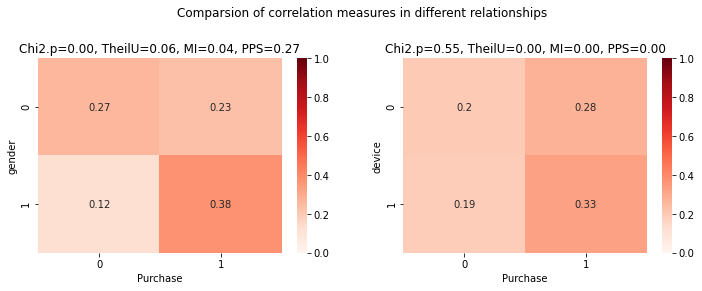

In [197]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(top=0.8) # for leaving some space for subtitle
fig.suptitle('Comparsion of correlation measures in different relationships')

cat_feas = ['gender','device']
#iterate through subplots and populate them
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(pd.crosstab(dataset[cat_feas[i]],dataset['purchase'],normalize=True),annot=True, cmap="Reds", ax=ax, vmin=0.0, vmax=1.0) # note that we could use Oranges_r to reverse the ordering
    ax.set(title="Chi2.p={:.2f}, TheilU={:.2f}, MI={:.2f}, PPS={:.2f}".format(*[j for j in all_corr[i]]), xlabel='Purchase')
plt.show()

For the left example, we simulate a relationship between purchase and gender. For example: There are more occurrences of purchases for gender(1) than gender(0). On the other hand, for the right example, there's not much relationship between them.

We could see that only Chi-sq(p-value<0.05) and PPS can reflect the reality of relationship well.

## Conclusion
PPS seems to be a reliable and general-purpose measure to quantify the association between all types of variables. And the goodness doesn't stop here. In this next page, we'll going to see how we can apply PPS to blaze through the time-consuming EDA process so that we can do high-impact work with the least time!